# 🚖 DATA Cleaning - 택시 요금 데이터 다루기 [프로젝트]

**분석자:** 박의진  
**데이터 파일:** `trip.csv`

---

##  1. 프로젝트 개요
본 프로젝트는 택시 운행 데이터(`trip.csv`)를 이용하여  
**요금(`fare_amount`) 예측을 위한 데이터 정제 및 탐색적 분석(EDA)** 을 수행하는 것을 목표로 한다.

### 데이터셋 포함 정보
- **tpep_pickup_datetime** : 승차 시각  
- **tpep_dropoff_datetime** : 하차 시각  
- **payment_method** : 지불 방법  
- **passenger_count** : 승객 수  
- **trip_distance** : 주행 거리 (mile 단위)  
- **fare_amount** : 기본 요금  
- **tip_amount** : 팁  
- **tolls_amount** : 톨비  
---
### 필수 실습 과제
1. **결측치 판단 및 처리**  
   - 각 변수별 결측치 유무 및 비율 확인  
   - 적절한 대체 또는 제거 방식 적용  

2. **이상치 판단 및 처리**  
   - 수치형 변수별로 인덱스-값 산점도를 통해 이상치 탐지  
   - 확인된 이상치는 제거하여 데이터 정제  

### 선택 실습 과제
- **변수 간 상관관계 탐색**  
  - 주행 시간, 거리, 요금 간의 관계 분석  
- **결제수단 단순화**  
  - payment_method의 Credit Card와 Debit Card를 통합하여 Card로 재분류  
---

> 💡 **분석 목적 요약**  
> 핵심 목표는 **요금 예측에 적합한 데이터 정제(Data Cleaning)** 이며,  
> 전처리를 통해 **신뢰도 높은 학습용 데이터셋**을 구성하는 것이다.


#Step 1. 환경 설정 및 데이터 불러오기

In [193]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [195]:
taxi_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/trip.csv')

In [196]:
taxi_df.head()

,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount
0,Pamela Duffy,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,Debit Card,6,3.34,13.0,2.76,0.0
1,Michelle Foster,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,Debit Card,1,1.80,16.0,4.00,0.0
2,Tina Combs,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,Debit Card,1,1.00,6.5,1.45,0.0
3,Anthony Ray,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,Cash,1,3.70,20.5,6.39,0.0
4,Brianna Johnson,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,Debit Card,1,4.37,16.5,0.00,0.0


In [197]:
#데이터 구조 점검
taxi_df.info()
taxi_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22701 entries, 0 to 22700
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   passenger_name         22701 non-null  object 
 1   tpep_pickup_datetime   22701 non-null  object 
 2   tpep_dropoff_datetime  22701 non-null  object 
 3   payment_method         22701 non-null  object 
 4   passenger_count        22701 non-null  int64  
 5   trip_distance          22701 non-null  float64
 6   fare_amount            22698 non-null  float64
 7   tip_amount             22701 non-null  float64
 8   tolls_amount           22701 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.6+ MB


(22701, 9)

In [198]:
#각 컬럼별 결측 비율 확인
taxi_miss = taxi_df.isna().mean().sort_values(ascending=False)
taxi_miss

,0
fare_amount,0.000132
passenger_name,0.000000
tpep_pickup_datetime,0.000000
payment_method,0.000000
tpep_dropoff_datetime,0.000000
passenger_count,0.000000
trip_distance,0.000000
tip_amount,0.000000
tolls_amount,0.000000


In [199]:
#결측치행 부분 확인
taxi_df[taxi_df['fare_amount'].isna()]

,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount
52,Benjamin Johnson,04/04/2017 4:22:03 PM,04/04/2017 4:35:30 PM,Cash,1,2.20,NaN,0.0,0.00
189,Maria Ibarra,08/21/2017 12:40:25 PM,08/21/2017 1:12:31 PM,Debit Card,3,15.20,NaN,5.0,0.00
244,Tina Avila,08/09/2017 8:32:09 AM,08/09/2017 9:31:11 AM,Cash,1,15.89,NaN,10.0,5.76


## Step 1-1. 구조 점검 결과

- 각 변수별 결측 비율을 계산한 결과`fare_amount`에서 약 **0.013% (3행)** 의 결측이 확인됨.
- 나머지 변수는 결측치 없음.

> 계획
- `fare_amount` 결측이 3행밖에 안되고 비용이 없다는 것이 비정상적이므로 제거 예정
- 그 외 다른 컬럼에서도 숨어있는 결측이 있는지수업시간에 배운것을 활용해 문자열 공백이나 논리적 범주안으로 필터링할 예정

#Step 2. 결측치 처리

In [200]:
#fare_amount 결측치 제거
taxi_df = taxi_df.dropna(subset=['fare_amount'])
taxi_df.isna().sum()

,0
passenger_name,0
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
payment_method,0
passenger_count,0
trip_distance,0
fare_amount,0
tip_amount,0
tolls_amount,0


In [201]:
#기타 문자열로 되어있는 컬럼의 숨은 결측이나 의미상 결측 등을 안전하게 제거하기
obj_cols = taxi_df.select_dtypes(include='object').columns
if len(obj_cols) > 0:
    # 앞뒤 공백 제거
    taxi_df[obj_cols] = taxi_df[obj_cols].apply(lambda s: s.str.strip())
    # 빈 문자열을 NaN으로 치환
    taxi_df[obj_cols] = taxi_df[obj_cols].replace({'': np.nan})

In [202]:
#논리상으로 이상하거나 비현실적 값 처리

#요금은 0보다는 커야 함
if 'fare_amount' in taxi_df.columns:
    taxi_df = taxi_df[taxi_df['fare_amount'] > 0]

#주행거리도 0보다는 커야 함
if 'trip_distance' in taxi_df.columns:
    taxi_df = taxi_df[taxi_df['trip_distance'] > 0]

#승객수도 0보다 크고 9보다는 작아야 함 (대형택시는 최대 8명까지 가능하다고 하며 11인승 이상 대형택시도 7인 승객 탑승을 권장한다고 함)
taxi_df = taxi_df[(taxi_df['passenger_count'] > 0) & (taxi_df['passenger_count'] < 9)]


In [203]:
taxi_df.describe()

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount
count,22501.000000,22501.000000,22501.000000,22501.000000,22501.000000
mean,1.645882,2.932710,12.974762,1.830778,0.309262
std,1.285585,3.655873,12.668360,2.767519,1.385330
min,1.000000,0.010000,0.010000,0.000000,0.000000
25%,1.000000,1.000000,6.500000,0.000000,0.000000
50%,1.000000,1.630000,9.500000,1.360000,0.000000
75%,2.000000,3.100000,14.500000,2.450000,0.000000
max,6.000000,33.960000,999.990000,200.000000,19.100000


#Step 2-1. 결측치 처리 결과
- 결측치 제거 및 숨은 결측 처리 완료
- 주요 변수들을 정상 범위로 정제


#Step 3.이상치 탐색 및 처리(Outlier Detection)


**목적:**  
- 데이터의 분포를 시각적으로 점검하고, 극단값(이상치)이 있는지 확인  
 (이상치는 모델의 학습 방향이나 통계적 해석을 왜곡시킬 수 있으므로)

**확인 대상 수치형 변수:**  
- `fare_amount` (요금)  
- `trip_distance` (주행 거리)  
- `passenger_count` (승객 수)

**확인 방법:**  
1. 인덱스 vs 값 **산점도(scatterplot)**  
2. 값 분포 확인을 위한 **박스플롯(boxplot)**



In [204]:
# 후보 변수 정렬해서 확인
taxi_df.sort_values(['fare_amount'], ascending=False).head(10)


,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount
8478,Alexis Hanson,02/06/2017 5:50:10 AM,02/06/2017 5:51:08 AM,Credit Card,1,2.60,999.99,200.00,0.00
13863,William Yates,05/19/2017 8:20:21 AM,05/19/2017 9:20:30 AM,Credit Card,1,33.92,200.01,51.64,5.76
3584,Matthew Chavez,01/01/2017 11:53:01 PM,01/01/2017 11:53:42 PM,Credit Card,1,7.30,152.00,0.00,0.00
9282,Samantha Frederick,06/18/2017 11:33:25 PM,06/19/2017 12:12:38 AM,Cash,2,33.96,150.00,0.00,0.00
16381,Erica Hernandez,11/30/2017 10:41:11 AM,11/30/2017 11:31:45 AM,Cash,1,25.50,140.00,0.00,16.26
10293,Emily Stevens,09/11/2017 11:41:04 AM,09/11/2017 12:18:58 PM,Cash,1,31.95,131.00,0.00,0.00
1930,Cameron Long,06/16/2017 6:30:08 PM,06/16/2017 7:18:50 PM,Debit Card,2,12.50,120.00,5.00,12.50
6066,Tina Knight,06/13/2017 12:30:22 PM,06/13/2017 1:37:51 PM,Debit Card,1,32.72,107.00,55.50,16.26
13623,Erica Byrd,11/04/2017 1:32:14 PM,11/04/2017 2:18:50 PM,Debit Card,2,19.80,105.00,8.00,2.64
910,Sue Hill,03/27/2017 1:01:38 PM,03/27/2017 1:38:44 PM,Credit Card,2,26.12,100.00,15.00,5.76


###**fare_amount**의 **max** 값이 튀는 걸 확인했고, 통계치 요약을 통해서도 재확인



In [205]:
taxi_df['fare_amount'].describe()

,fare_amount
count,22501.000000
mean,12.974762
std,12.668360
min,0.010000
25%,6.500000
50%,9.500000
75%,14.500000
max,999.990000


<function matplotlib.pyplot.show(close=None, block=None)>

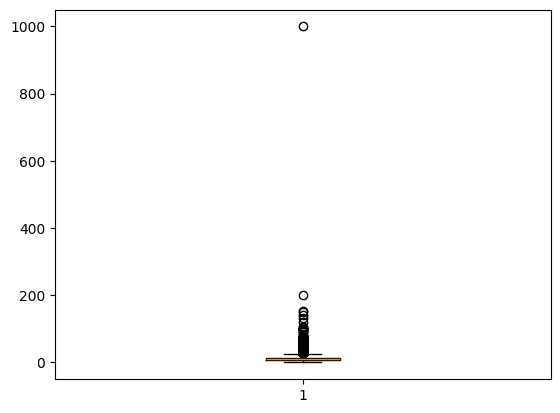

In [206]:
plt.boxplot(taxi_df['fare_amount'])
plt.show

In [207]:
# 900이상 되는 이상치는 비정상이라서 제거
taxi_df = taxi_df[taxi_df['fare_amount'] < 900]
taxi_df.describe()

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount
count,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000
mean,1.645911,2.932725,12.930894,1.821970,0.309276
std,1.285606,3.655954,10.825567,2.431865,1.385359
min,1.000000,0.010000,0.010000,0.000000,0.000000
25%,1.000000,1.000000,6.500000,0.000000,0.000000
50%,1.000000,1.630000,9.500000,1.360000,0.000000
75%,2.000000,3.100000,14.500000,2.450000,0.000000
max,6.000000,33.960000,200.010000,55.500000,19.100000


##**변수별 산점도**를 통해 이상치 탐지

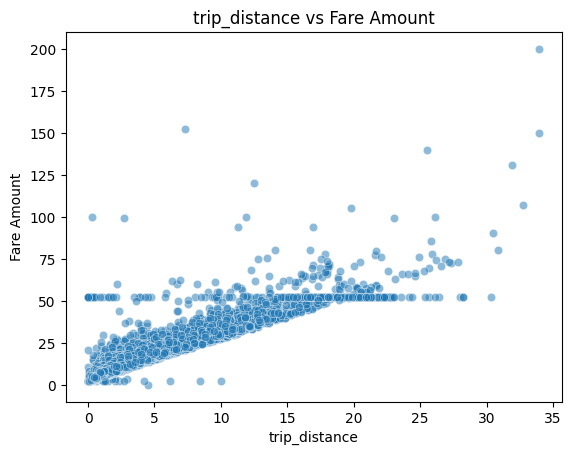

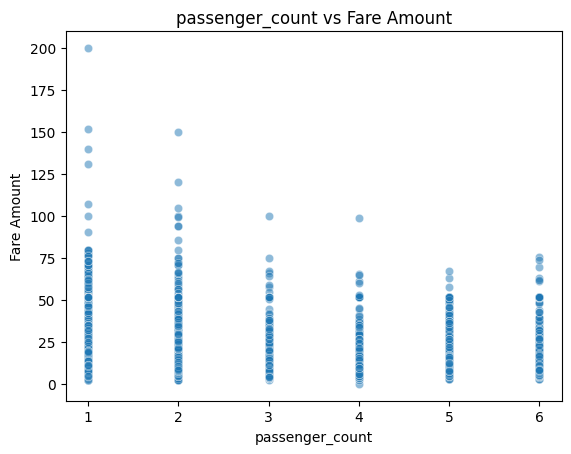

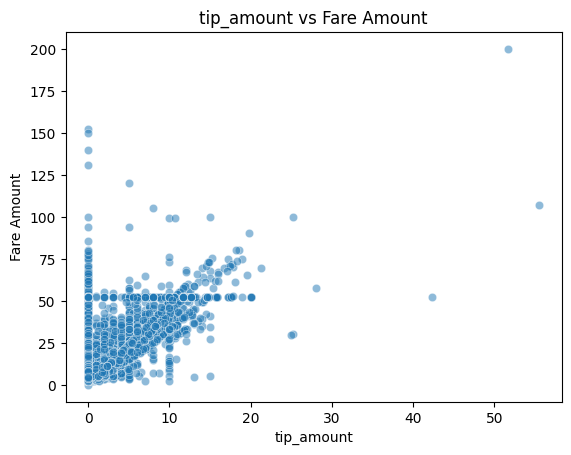

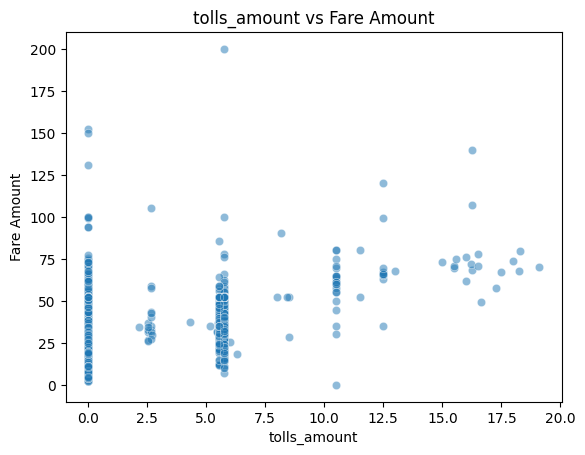

In [208]:
#수치형 변수 리스트 만듦
num_cols = ['trip_distance', 'passenger_count', 'tip_amount', 'tolls_amount']

for col in num_cols:
    #요금과의 관계를 보고 싶은 변수리스트를 대입
    sns.scatterplot(x=col, y='fare_amount', data=taxi_df, alpha=0.5)
    plt.title(f"{col} vs Fare Amount")
    plt.xlabel(col)
    plt.ylabel("Fare Amount")
    plt.show()

##Step3-1. 요금과 다른 수치형 변수들과의 산점도 그래프 결과 해석

의미 : 변수별 요금(fare_amount) 관계 탐색을 위해 산점도를 확인했고, 상관성 여부 및 이상치 패턴을 시각적으로 점검함

**결과**

---

1) trip_distance


	•	거리 길수록 요금 증가 → 명확한 양의 상관관계
	•	일부 예외값 존재하나 전반적으로 선형적 추세

>해석: 거리 변수는 요금에 가장 직접적인 영향 요인
---

2) passenger_count


	•	승객 수와 요금 간 뚜렷한 관계 없음
	•	분산이 넓고 패턴 불분명

>해석: 요금 산정에는 영향이 거의 없는 보조 변수
---

3) tip_amount


	•	요금 높을수록 팁도 함께 증가 → 강한 양의 상관관계

>해석: 팁은 운행 금액에 연관된 변수
 ---

4) tolls_amount


	•	뚜렷한 상관관계는 보이지 않음. 대부분 0~5달러 구간에 집중

>해석: 톨비는 요금 일부지만 주요 결정 변수는 아님
---

✅ 종합 요약

	•	trip_distance, tip_amount → 요금과 뚜렷한 양의 관계
	•	passenger_count, tolls_amount → 영향 미미
	•	이상치(900 이상) 제거 후 분포 안정화로 분석 신뢰도 향상



#Step4. 상관관계 분석
- 위의 과정을 통해 대략적으로 요금을 중심으로 어떤 변수가 가장 연관이 있을지 예측함.
- 주행거리가 요금과 가장 연관성이 높고, 팁은 관련성이 있는 변수임.
- 해당 가정을 검증하기 위해 corr 를 써서 확인하고 Heatmap으로 시각화 함.

**분석 포인트**
붉은색 짙을수록 , 높은 상관계수 : 양의 상관
파란색 짙을 수록, 낮은 상관계수 : 무관



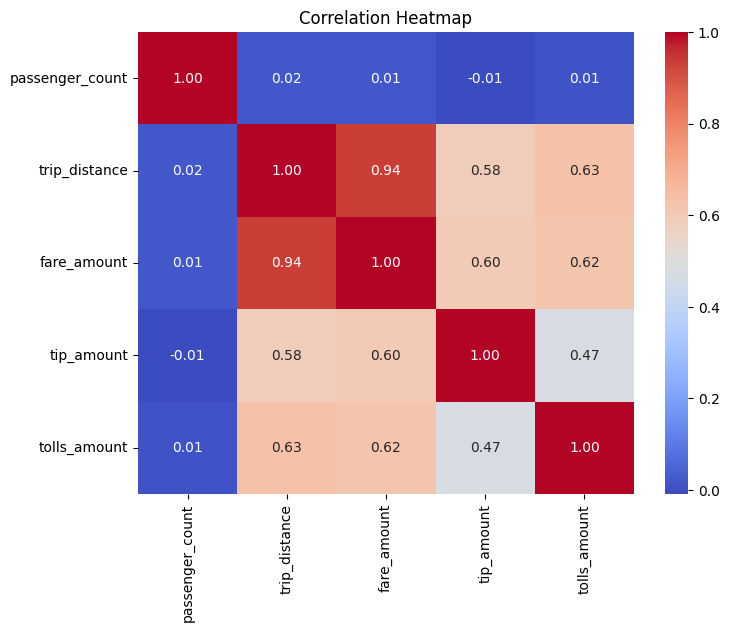

In [209]:
corr = taxi_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

##Step 4-1. 변수별 상관관계 분석 결과

1) 상관 계수 결과를 분석한 결과 요금과 다른 변수들 간에는 아래와 같은 경향이 관찰됨
- **trip_distance (높은 양의 상관관계 : 0.94)** : 주행거리가 길수록 요금이 증가, 즉 요금의 핵심 변수
- **tip_amount (중간 이상의 양의 상관관계 : 0.6)** : 팁금액이 증가하면 높은 요금 경향
- **toll_amount (중간 이상의 양의 상관관계 0.62)** : 톨금액이 증가하면 높은 요금 경향
- **passenger_count (거의 무관 : 0.01)** : 승객수는 요금과 연관성이 거의 없음

2) 시각화 결과


- 빨간색 (양의 상관) 구간을 살펴보면 **fare_amount**와 **trip_distance**, **fare_amount**와 **tip_amount** 에서 강하게 나타남.

- 결론적으로 **요금 예측 주요 설명 변수는 trip_distance일 확률이 매우 높다.** 그리고 팁과 톨비도 요금에 영향은 미칠 수 있으나 보조적 예측변수로 유의미하다고 보여짐


- 그 외 **toll_amount**와 **trip_distance** 간에도 0.63의 중간 이상의 양의 상관 관계가 관찰된 것으로 보아, 운행 거리가 길수록 톨비 증가 가능성이 존재함을 알 수 있음.

- passenger_count는 요금 예측 모델 성능에는 기여도가 크지 않을 변수로 예측됨.


#Step 5. 선택 실습 - 결제수단 단순화

In [210]:
# 이름 교체
taxi_df['payment_method'] = taxi_df['payment_method'].replace({'Credit Card': 'Card', 'Debit Card': 'Card'})

In [211]:
taxi_df['payment_method'].value_counts()

,count
payment_method,
Card,11403
Cash,11097


###결제 방식을 현금과 카드로 새롭게 카테고리화 하였음.
- 이러한 변수는 나중에 카드 결제와 현금 결제간의 패턴 차이를 확인할 수 있음
- 예) 카드 결제가 더 큰 팁을 유도할까? 요금이 올라가면 현금보다 카드결제를 선호할까?
- 나중에 모델링 할 때 원핫인코딩으로 변환처리 가능한 변수가 됨

In [212]:
# 결제 방식별 평균 요금 비교

taxi_df.groupby('payment_method')['fare_amount'].mean()

,fare_amount
payment_method,
Card,12.972056
Cash,12.888597


### 카드나 현금이나 지불방법의 종류가 요금에는 큰 영향을 미치는 것처럼 보이지 않음

In [213]:
#결제 방식별 팁 요금 비교
taxi_df.groupby('payment_method')['tip_amount'].mean()

,tip_amount
payment_method,
Card,1.826027
Cash,1.817801


###지불방법의 종류가 팁 금액에 큰 영향을 미치는 것처럼 보이지 않음

#프로젝트 회고

이번 프로젝트는 택시 요금(`fare_amount`) 예측을 위한 데이터 클리닝 및 탐색적 분석을 수행한 것으로, 단순 결측치·이상치 제거 실습을 하는 것에서 그치지 않고, **데이터의 논리성과 변수 간 상관관계의**까지 생각해 볼 수 있는 경험이었다.

---

### ✨ 배운 점 & 성장
- 결측치 처리는 단순 제거와 채우는 것이 아니고, 그에 대한 논리적 근거와 기준 설정이 중요함을 배움.
  (예: 요금 0원은 비정상 → 제거, `passenger_count`는 웹 검색을 통해 일반 택시와 대형택시 승객수 논리에 맞는 범위로 제한)
- 이상치 탐색은 **IQR로 접근하는게 어려워서 일단 시각화(산점도)**를 적용해 데이터의 분포를 직관적으로 이해할 수 있었음.
- **상관관계 분석과 히트맵 시각화**를 통해 변수 간 관계를 직관적으로 파악하고 결과를 해석하는 경험을 쌓음.

---

### 🔍 느낀 한계 & 보완 방향
- 수업한 지 하루 지나서 프로젝트 하려니 두뇌가 리셋됨. 공부한 파일을 다시 찾아서 적용하려니 쉽지 않음.
- 승하차 시간 정보는 `datetime`을 가지고 **운행 시간 기반 변수(예: 주행 소요시간)**를 만들어 분석에 활용해볼 수 있었을텐데 본 프로젝트에서는 주요 미션과 시간을 고려해서 다루지 못했음.
- 이상치 제거 기준(요금 > 900)은 **시각적, 경험적 판단**에 의존했음.  
  → 이후 통계적 기준(IQR 또는 Z-score)을 병행해 검증할 수도 있다고 하는데 이해가 충분히 되지 않아서 통계공부 한 이후에 추가로 해보면 좋을 듯함.
---

### 🚀 앞으로의 계획
- 이러한 전처리 결과를 기반으로 **요금 예측 모델(회귀분석)** 로 넘어간다고 하니 모델링 부분에도 관심이 생겼음.  
- 데이터 분석 과정에서 “무엇을, 왜 이렇게 처리했는가”를 명확히 설명하는 루틴을 갖자.
- 마크다운을 통해 코드와 해석을 함께 기록하는 **리포트형 분석 방식**을 지속적으로 연습 필요

---

> 이번 프로젝트를 통해 ‘데이터 클리닝’이 분석의 가장 기초적인 단계인데 이 과정에서도  
> **분석가의 사고력과 논리적 판단이 중요하다는 것**을 실감했다.